In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context("talk")

In [3]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

r = robjects.r

nsn = importr("NanoStringNorm")
egr = importr("edgeR")

py = pandas2ri.ri2py

In [4]:
cell_type = 'Treg'

# Read in RCC data

In [5]:
base_path = u'/home/gus/MEGAsync/zim/main/BCH/Projects/James/Nanostring_pipeline/OKT3/data/compare_ours_to_existing/treg'

our_rcc_path = base_path+u"/ours"
thr_rcc_path = base_path+u"/theirs"

In [6]:
our_data = py(r(u"""read.markup.RCC(rcc.path="{PATH}")""".format(PATH=our_rcc_path)).rx2('x'))
thr_data = py(r(u"""read.markup.RCC(rcc.path="{PATH}")""".format(PATH=thr_rcc_path)).rx2('x'))

In [7]:
our_data.shape

(608, 8)

In [8]:
thr_data.shape

(540, 6)

In [9]:
our_data.head()

,CodeClass,Name,Accession,BWH006_Treg_w0_12,BWH008_Treg_w0_01,MGH001_Treg_w0_04,MGH004_Treg_w0_01,MGH007_Treg_w0_09
1,Endogenous,VTN,NM_000638.3,2,2,3,0,0
2,Endogenous,HLA-DQB1,NM_002123.3,2,0,2,0,0
3,Endogenous,KIT,NM_000222.2,1,2,1,0,1
4,Endogenous,LAG3,NM_002286.5,1,0,4,2,1
5,Endogenous,SOCS3,NM_003955.3,1,1,5,0,2


In [10]:
our_genes = set(our_data.Name.unique())
thr_genes = set(thr_data.Name.unique())

In [11]:
len(our_genes.intersection(thr_genes))

520

## Join tables by gene names

- We will only deal with the genes that are in commen between the tables from now on
- thats 520 including the pos/neg controls etc.

In [12]:
cmb_data = pd.merge(left=our_data, right=thr_data,
                    how='inner', on="Name",
                    left_on=None, right_on=None,
                    left_index=False, right_index=False,
                    sort=False, suffixes=('_OUR', '_THR'), copy=True, indicator=False)

cmb_data.index = cmb_data.Name.values
cmb_data = cmb_data.drop(labels=['Name'],axis=1)
cmb_data.head()

,CodeClass_OUR,Accession_OUR,BWH006_Treg_w0_12,BWH008_Treg_w0_01,MGH001_Treg_w0_04,MGH004_Treg_w0_01,MGH007_Treg_w0_09,CodeClass_THR,Accession_THR,GSM1515480_tTreg,GSM1515483_tTreg,GSM1515486_tTreg
VTN,Endogenous,NM_000638.3,2,2,3,0,0,Endogenous,NM_000638.3,21,5,15
HLA-DQB1,Endogenous,NM_002123.3,2,0,2,0,0,Endogenous,NM_002123.3,9,6,12
KIT,Endogenous,NM_000222.2,1,2,1,0,1,Endogenous,NM_000222.1,68,21,65
SOCS3,Endogenous,NM_003955.3,1,1,5,0,2,Endogenous,NM_003955.3,68,36,74
TCF7,Endogenous,NM_003202.2,3,3,2,5,16,Endogenous,NM_003202.2,319,104,309


In [13]:
code_class_missmatch = cmb_data.CodeClass_OUR != cmb_data.CodeClass_THR
sum(code_class_missmatch)

15

15 rows have CodeClass designations that don't match up...

In [14]:
cmb_data[code_class_missmatch][['CodeClass_OUR','CodeClass_THR']]

,CodeClass_OUR,CodeClass_THR
EEF1G,Housekeeping,Endogenous
TUBB,Housekeeping,Endogenous
TBP,Housekeeping,Endogenous
POLR2A,Housekeeping,Endogenous
GUSB,Housekeeping,Endogenous
HPRT1,Housekeeping,Endogenous
GAPDH,Housekeeping,Endogenous
SDHA,Housekeeping,Endogenous
OAZ1,Housekeeping,Endogenous
PPIA,Housekeeping,Endogenous


Looks like its not too big a deal.  They just added some genes as housekeepers.

## OK lets get rid of CodeClass and Accession Columns and write to file

In [15]:
cmb_data_extra_cols = cmb_data[['CodeClass_OUR','Accession_OUR','CodeClass_THR','Accession_THR']].copy()

cmb_data = cmb_data.drop(labels=['CodeClass_OUR','Accession_OUR','CodeClass_THR','Accession_THR'],axis=1)

In [16]:
print cmb_data.columns.values

['BWH006_Treg_w0_12' 'BWH008_Treg_w0_01' 'MGH001_Treg_w0_04'
 'MGH004_Treg_w0_01' 'MGH007_Treg_w0_09' 'GSM1515480_tTreg'
 'GSM1515483_tTreg' 'GSM1515486_tTreg']


In [17]:
cmb_data_path = base_path+u"/combo_nanostring_data.csv"
cmb_data.to_csv(path_or_buf=cmb_data_path, 
           columns=None, header=True, index=True,)

## Write out the target table

In [18]:
targets = cmb_data.T.iloc[:,0:2].copy()
targets[u'source'] = targets.index.values
targets.source = targets.source.apply(lambda i: 'THEIRS' if i.startswith('GSM') else 'OURS' )
targets = pd.DataFrame(targets.source)
targets

,source
BWH006_Treg_w0_12,OURS
BWH008_Treg_w0_01,OURS
MGH001_Treg_w0_04,OURS
MGH004_Treg_w0_01,OURS
MGH007_Treg_w0_09,OURS
GSM1515480_tTreg,THEIRS
GSM1515483_tTreg,THEIRS
GSM1515486_tTreg,THEIRS


In [19]:
targets_path = base_path+u"/targets.csv"
targets.to_csv(path_or_buf=targets_path, 
           columns=None, header=True, index=True)

# EdgeR is used to perform normalization

In [20]:
x = py(r(u"""x <- read.delim("{PATH}", sep = ',', row.names=1) """.format(PATH=cmb_data_path)))

# Sort column names
x = py(r(u""" x <- x[,order(colnames(x))] """))

In [21]:
print r(u"head(x)")

         BWH006_Treg_w0_12 BWH008_Treg_w0_01 GSM1515480_tTreg GSM1515483_tTreg
VTN                      2                 2               21                5
HLA-DQB1                 2                 0                9                6
KIT                      1                 2               68               21
SOCS3                    1                 1               68               36
TCF7                     3                 3              319              104
IKBKB                    1                 1               87               56
         GSM1515486_tTreg MGH001_Treg_w0_04 MGH004_Treg_w0_01 MGH007_Treg_w0_09
VTN                    15                 3                 0                 0
HLA-DQB1               12                 2                 0                 0
KIT                    65                 1                 0                 1
SOCS3                  74                 5                 0                 2
TCF7                  309                 2    

In [22]:
x.head()

,BWH006_Treg_w0_12,BWH008_Treg_w0_01,GSM1515480_tTreg,GSM1515483_tTreg,GSM1515486_tTreg,MGH001_Treg_w0_04,MGH004_Treg_w0_01,MGH007_Treg_w0_09
VTN,2,2,21,5,15,3,0,0
HLA-DQB1,2,0,9,6,12,2,0,0
KIT,1,2,68,21,65,1,0,1
SOCS3,1,1,68,36,74,5,0,2
TCF7,3,3,319,104,309,2,5,16


In [23]:
r("""# read in target annotations for the design matrix stuff later
targets <- read.table("{PATH}",sep = ',', header = TRUE, row.names = 1)
#targets <- targets[order(rownames(targets)),]
targets <- lapply(targets,factor)

# create the DEGList object
y <- DGEList(counts=x,group=targets$source)


# Filter for counts
#keep <- rowSums(y>30) >= 2
#y <- y[keep, , keep.lib.sizes=FALSE]

# TMM normalization factors
y <- calcNormFactors(y)
""".format(PATH=targets_path))

<ListVector - Python:0x7fa311e2c128 / R:0x66b9238>
[Matrix, DataFrame]
  counts: <class 'rpy2.robjects.vectors.Matrix'>
  <Matrix - Python:0x7fa311e2c680 / R:0x6509030>
[       2,        2,        1, ...,        2,        3,        4]
<ListVector - Python:0x7fa311e2c128 / R:0x66b9238>
[Matrix, DataFrame]

In [24]:
n = py(r("n <- cpm(y)"))
n_rows = py(r("rownames(n)"))
n_cols = py(r("colnames(n)"))

In [25]:
y_norm = pd.DataFrame(n, columns=n_cols, index=n_rows)

In [26]:
y_norm.T

,VTN,HLA-DQB1,KIT,SOCS3,TCF7,IKBKB,ITGA6,CXCR4,NFKBIZ,MAPK14,...,HPRT1,GAPDH,SDHA,OAZ1,PPIA,G6PD,RPL19,POLR1B,ABCF1,ALAS1
BWH006_Treg_w0_12,103.343927,103.343927,51.671963,51.671963,155.015890,51.671963,361.703744,568.391598,206.687854,103.343927,...,51.671963,413.375708,155.015890,413.375708,155.015890,103.343927,2118.550502,103.343927,103.343927,0.000000
BWH008_Treg_w0_01,99.580848,0.000000,99.580848,49.790424,149.371272,49.790424,49.790424,149.371272,348.532969,99.580848,...,49.790424,199.161696,49.790424,199.161696,49.790424,49.790424,448.113817,0.000000,49.790424,49.790424
GSM1515480_tTreg,62.926221,26.968380,203.761096,203.761096,955.879258,260.694343,551.353553,904.938984,1066.749266,386.546785,...,41.950814,218.743529,338.602997,47.943787,149.824335,95.887574,1225.563061,44.947301,134.841902,56.933247
GSM1515483_tTreg,36.938342,44.326010,155.141036,265.956061,768.317509,413.709428,443.260101,1255.903621,1292.841963,369.383418,...,51.713679,369.383418,325.057408,29.550673,229.017719,81.264352,1255.903621,66.489015,192.079377,51.713679
GSM1515486_tTreg,45.993872,36.795098,199.306779,226.903103,947.473767,294.360782,429.276140,2161.711992,818.690925,288.228266,...,73.590195,245.300652,355.685945,73.590195,202.373038,104.252777,2903.746464,52.126388,137.981617,61.325163
MGH001_Treg_w0_04,46.040797,30.693865,15.346932,76.734661,30.693865,92.081594,230.203984,260.897849,153.469323,122.775458,...,153.469323,567.836494,61.387729,184.163187,30.693865,107.428526,352.979442,61.387729,168.816255,153.469323
MGH004_Treg_w0_01,0.000000,0.000000,0.000000,0.000000,199.454270,119.672562,119.672562,319.126831,39.890854,119.672562,...,79.781708,1196.725618,79.781708,279.235977,39.890854,0.000000,3191.268314,0.000000,39.890854,79.781708
MGH007_Treg_w0_09,0.000000,0.000000,38.135882,76.271764,610.174112,190.679410,572.038230,2364.424682,228.815292,190.679410,...,152.543528,1525.435279,38.135882,457.630584,152.543528,38.135882,3966.131725,76.271764,114.407646,152.543528


In [27]:
cmb_cpm = pd.merge(left=targets, right=y_norm.T, 
                   how='inner', on=None, 
                   left_on=None, right_on=None, 
                   left_index=True, right_index=True, 
                   sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)

In [28]:
cmb_cpm_mean = cmb_cpm.groupby('source').mean()
cmb_cpm_mean = cmb_cpm_mean.T

/home/gus/anaconda2/envs/stack2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


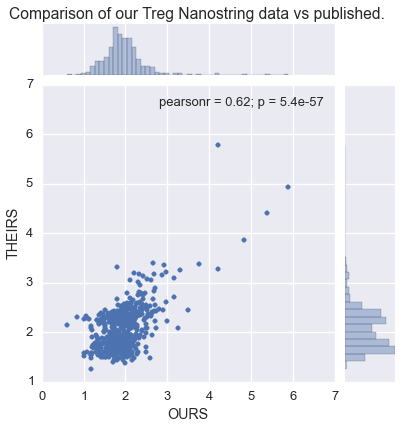

In [29]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean+1), kind='scatter',
             );

plt.suptitle("Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

### Lets look at the external controls

In [30]:
cmb_data_extra_cols.head()

,CodeClass_OUR,Accession_OUR,CodeClass_THR,Accession_THR
VTN,Endogenous,NM_000638.3,Endogenous,NM_000638.3
HLA-DQB1,Endogenous,NM_002123.3,Endogenous,NM_002123.3
KIT,Endogenous,NM_000222.2,Endogenous,NM_000222.1
SOCS3,Endogenous,NM_003955.3,Endogenous,NM_003955.3
TCF7,Endogenous,NM_003202.2,Endogenous,NM_003202.2


In [31]:
cmb_data_extra_cols.CodeClass_OUR.unique()

array(['Endogenous', 'Positive', 'Negative', 'Housekeeping'], dtype=object)

In [32]:
cmb_data_extra_cols.CodeClass_THR.unique()

array(['Endogenous', 'Positive', 'Negative'], dtype=object)

In [33]:
pos_ctrl = list(cmb_data_extra_cols.query(""" CodeClass_OUR == "Positive" """).index.values)
neg_ctrl = list(cmb_data_extra_cols.query(""" CodeClass_OUR == "Negative" """).index.values)
hsk_gene = list(cmb_data_extra_cols.query(""" CodeClass_OUR == "Housekeeping" """).index.values)
bth_ctrl = pos_ctrl + neg_ctrl
pan_gene = list(cmb_data_extra_cols[cmb_data_extra_cols.CodeClass_OUR.apply(lambda i: i in ['Housekeeping','Endogenous'])].index.values)

In [34]:
bth_ctrl

['POS_C(8)',
 'POS_A(128)',
 'POS_F(0.125)',
 'POS_D(2)',
 'POS_B(32)',
 'POS_E(0.5)',
 'NEG_C(0)',
 'NEG_D(0)',
 'NEG_E(0)',
 'NEG_A(0)',
 'NEG_H(0)',
 'NEG_G(0)',
 'NEG_F(0)',
 'NEG_B(0)']

In [35]:
cmb_cpm_mean.head()

source,OURS,THEIRS
VTN,49.793114,48.619478
HLA-DQB1,26.807558,36.029829
KIT,40.947125,186.069637
SOCS3,50.893763,232.206753
TCF7,228.941882,890.556845


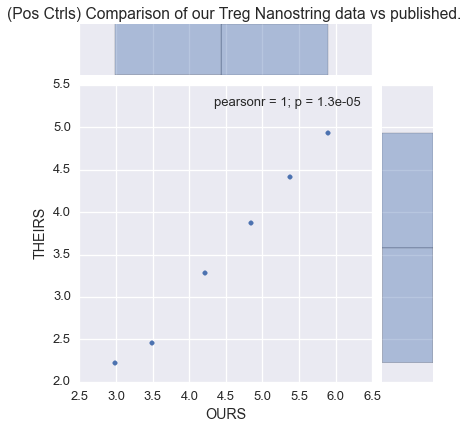

In [36]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[pos_ctrl]+1), kind='scatter',
             );

plt.suptitle("(Pos Ctrls) Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

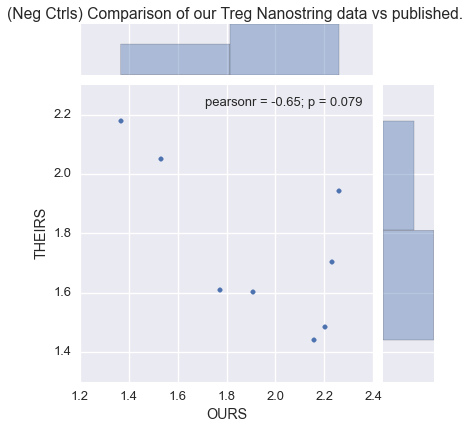

In [37]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[neg_ctrl]+1), kind='scatter',
             );

plt.suptitle("(Neg Ctrls) Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

In [38]:
cmb_cpm_mean.loc[neg_ctrl].head()

source,OURS,THEIRS
NEG_C(0),180.890133,86.716737
NEG_D(0),80.032229,39.096088
NEG_E(0),58.110832,39.583504
NEG_A(0),168.693720,49.571793
NEG_H(0),32.932193,111.364816


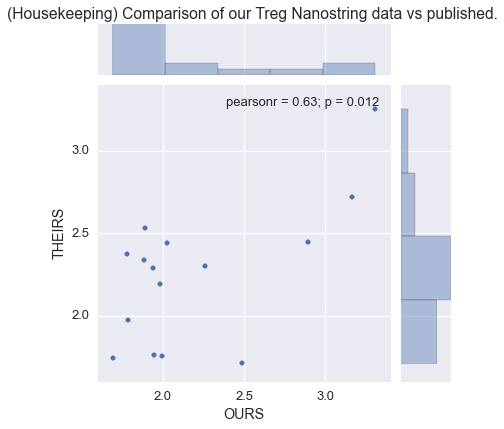

In [39]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[hsk_gene]+1), kind='scatter',
             );

plt.suptitle("(Housekeeping) Comparison of our {cell} Nanostring data vs published.".format(cell=cell_type), y=1,);

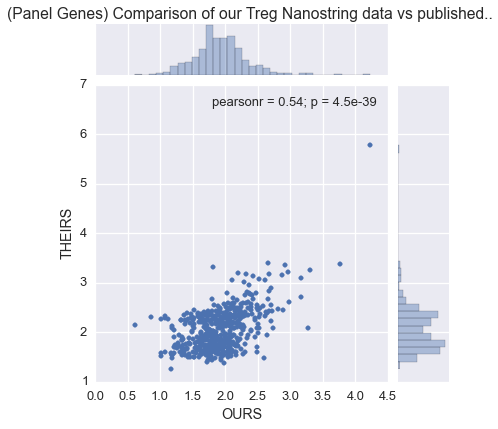

In [40]:
sns.jointplot(x='OURS', y='THEIRS',
              data=np.log10(cmb_cpm_mean.loc[pan_gene]+1), kind='scatter',
             );

plt.suptitle("(Panel Genes) Comparison of our {cell} Nanostring data vs published..".format(cell=cell_type), y=1,);